# Submissions

In [140]:
from sklearn import datasets
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import matplotlib.pyplot as plt
from __future__ import division
import pandas as pd
import numpy as np
import pickle
%matplotlib inline

#iris = datasets.load_iris()
#X, y = iris.data[:, 1:3], iris.target
df = pd.read_csv("Matchup_KP.csv")
features = ['FieldGoalAvg', 'ThreePointAvg', 'FreeThrowAvg', 'ReboundAvg', 'AssistAvg', 'TurnOverAvg', 
            'StealAvg', 'BlockAvg', 'PersonalFoulAvg', 'Pyth', 'Rank', 'AdjustO', 'AdjustO Rank', 'AdjustD', 
            'AdjustD Rank', 'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank']
features2 = ['Pyth', 'Rank', 'AdjustO', 'AdjustO Rank', 'AdjustD', 
            'AdjustD Rank', 'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank']
# Load Elo Ratings (dict)
team_elos = pickle.load(open("../elo/data/team_elos.p", "rb"))
# Extremely Random Forest Features
features3 = ['Pyth', 'AdjustO', 'AdjustD', 'Luck','FieldGoalAvg']
# Random Forest Features
features4 = ['Pyth', 'AdjustO', 'AdjustD', 'Luck','BlockAvg']
# Gradient Boosting Features
features5 = ['Pyth', 'AdjustO', 'Luck','BlockAvg','AssistAvg']
#ADA Boost
features6 = ['Pyth','Luck','AdjustO','AdjustD','FieldGoalAvg']

In [141]:
Submission = pd.read_csv("2016Submission.csv")
submission_test = Submission[features2]

X = df[features2]
y = df.WinLoss

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=None)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
#Accuracy: 0.93 (+/- 0.05) [Random Forest]
#Accuracy: 0.91 (+/- 0.04) [naive Bayes]
#Accuracy: 0.95 (+/- 0.05) [Ensemble]

Accuracy: 0.79 (+/- 0.03) [Logistic Regression]
Accuracy: 0.75 (+/- 0.04) [Random Forest]
Accuracy: 0.79 (+/- 0.03) [naive Bayes]
Accuracy: 0.79 (+/- 0.03) [Ensemble]


In [142]:
def score_model(model, parameters, X_train, y_train, X_test, y_test):
    m = model()
    m = GridSearchCV(m, parameters)
    m.fit(X_train, y_train)
    score = m.score(X_test, y_test)
    return m.best_estimator_, score, m.best_params_

def score_voting_model(model, parameters, X_train, y_train, X_test, y_test):
    m = model(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])
    m = GridSearchCV(m, parameters, cv= 3)
    m.fit(X_train, y_train)
    score = m.score(X_test, y_test)
    return m.best_estimator_, score, m.best_params_

In [143]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
    plt.yticks(tick_marks, ['Loss', 'Win'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def accuracies(cm):
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    print("Loss Acc: {0}".format(no_acc))
    print("Win Acc: {0}".format(yes_acc))
    print("Avg Acc: {0}".format((no_acc + yes_acc)/2))
    

def run_model(model):
    clf = model
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm)
    accuracies(cm)

In [144]:
def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]
        
def get_elo_diff(team_1, team_2, season):
    elo1 = get_elo(season, team_1)
    elo2 = get_elo(season, team_2)
    return elo1 - elo2

In [145]:
def append_elos():
    dFrames = [df, Submission]
    for i, dFrame in enumerate(dFrames):
        elo_diffs = []
        for index, row in dFrame.iterrows():
            elo_diffs.append(get_elo_diff(row['Wteam'], row['Lteam'], row['Year']))
        elos = pd.DataFrame(elo_diffs, columns = ['Elo Rank'])
        if i==0:
            X_elos = pd.concat([X, elos], axis=1)
        else:
            submission_elos = pd.concat([submission_test, elos], axis=1)
    return X_elos, submission_elos

# Logistic Regression

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

('Logistic Regression Score:', 0.79385171790235076)
('Logistic Regression Parameters:', {'penalty': 'l2', 'C': 0.1, 'solver': 'liblinear'})
[[239  56]
 [ 58 200]]


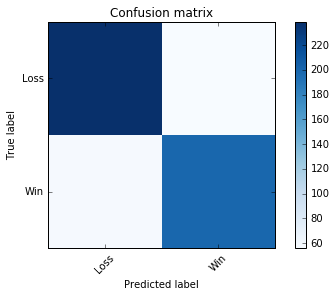

Loss Acc: 0.810169491525
Win Acc: 0.77519379845
Avg Acc: 0.792681644988


In [147]:
param_clf1 = {'penalty':['l1', 'l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver':['liblinear']}
clf1, clf1_s, param_clf1 = score_model(LogisticRegression, param_clf1, X_train, y_train, X_test, y_test)
print('Logistic Regression Score:', clf1_s)
print('Logistic Regression Parameters:', param_clf1)
run_model(clf1)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [148]:
predictions = clf1.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
LogisticRegressionSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
LogisticRegressionSubmission.to_csv("LogisticRegressionSubmission2.csv",index = False)

# Random Forest

('Random Forest Score:', 0.77034358047016271)
('Random Forest Parameters:', {'max_features': 'sqrt', 'n_estimators': 300})
[[232  63]
 [ 67 191]]


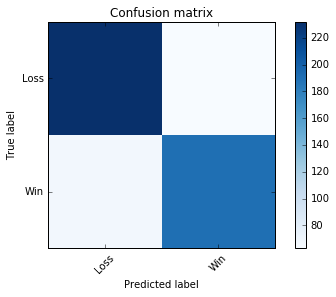

Loss Acc: 0.786440677966
Win Acc: 0.740310077519
Avg Acc: 0.763375377743


In [149]:
#p = {'n_estimators':[10, 50, 100, 300, 500, 1000,1500], 'max_features': [ None, 'auto', 'sqrt', 'log2']}
p = {'n_estimators':[10, 50, 100, 300, 500, 1000], 'max_features': [ None, 'auto', 'sqrt', 'log2']}
clf2, clf2_s, param_clf2 = score_model(RandomForestClassifier, p, X_train, y_train, X_test, y_test)

print('Random Forest Score:', clf2_s)
print('Random Forest Parameters:', param_clf2)
run_model(clf2)

In [150]:
predictions = clf2.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
RandomForestSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
RandomForestSubmission.to_csv("RandomForestSubmission2.csv",index = False)

# Extremely Randomized Trees

In [151]:
p = {'n_estimators':[10, 50, 100], 'max_features': ['sqrt']}
m_RF, RF_s, param_RF = score_model(ExtraTreesClassifier, p, X_train, y_train, X_test, y_test)

print('Random Forest Score:', RF_s)
print('Random Forest Parameters:', param_RF)

('Random Forest Score:', 0.75045207956600357)
('Random Forest Parameters:', {'max_features': 'sqrt', 'n_estimators': 100})


[[231  64]
 [ 67 191]]


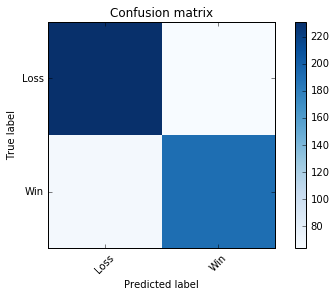

Loss Acc: 0.783050847458
Win Acc: 0.740310077519
Avg Acc: 0.761680462489


In [152]:
run_model(m_RF)

In [153]:
predictions = m_RF.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
ExtremelyRandomForestSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
ExtremelyRandomForestSubmission.to_csv("ExtremelyRandomForestSubmission2.csv",index = False)

# Naive Bayes

[[241  54]
 [ 70 188]]


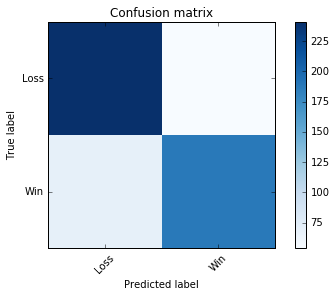

Loss Acc: 0.816949152542
Win Acc: 0.728682170543
Avg Acc: 0.772815661543


In [154]:
clf3.fit(X_train, y_train)
clf3.score(X_test, y_test)
run_model(clf3)

In [155]:
predictions = clf3.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
NaiveBayesSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
NaiveBayesSubmission.to_csv("NaiveBayesSubmission2.csv",index = False)

# Voting Classifier Ensemble

[[240  55]
 [ 58 200]]


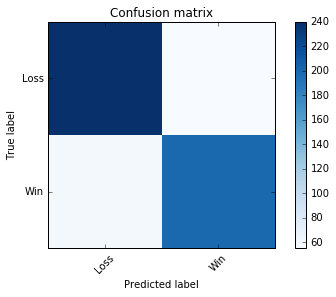

Loss Acc: 0.813559322034
Win Acc: 0.77519379845
Avg Acc: 0.794376560242
('Voting Classifier Score:', 0.79566003616636527)
('Voting Classifier Parameters:', {'voting': 'soft', 'weights': [0.99, 0.05, 0.05]})


In [156]:
param_eclf = {'voting':['soft','hard'], 'weights': [[.99,.05,.05],[.79,.75,.79]]}
eclf, eclf_s, param_eclf = score_voting_model(VotingClassifier, param_eclf, X_train, y_train, X_test, y_test)
run_model(eclf)
print('Voting Classifier Score:', eclf_s)
print('Voting Classifier Parameters:', param_eclf)

In [157]:
predictions = clf3.predict_proba(submission_test)
Submission.Pred = predictions[:,1]
EnsembleSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
EnsembleSubmission.to_csv("EnsembleSubmission2.csv",index = False)

# Gradient Boost

In [158]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
param_gclf = {'n_estimators':[10, 50, 100, 500, 1000], 
              'learning_rate':[0.01], 
              'loss':['ls',], 
              'random_state':[42]}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

gclf = GradientBoostingRegressor()
grid = GridSearchCV(gclf, param_gclf, cv=3)
grid.fit(X_train, y_train)
gclf = grid.best_estimator_
mse = mean_squared_error(y_test, gclf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.1662


In [159]:
print('Gradient Score:', eclf_s)
print('Gradient Parameters:', param_gclf)

('Gradient Score:', 0.79566003616636527)
('Gradient Parameters:', {'n_estimators': [10, 50, 100, 500, 1000], 'loss': ['ls'], 'learning_rate': [0.01], 'random_state': [42]})


In [109]:
#predictions = gclf.predict_proba(submission_test)
#Submission.Pred = predictions[:,1]
#GradientBoostingSubmission = Submission[['Id','Pred']].sort_values(by = 'Id')
#GradientBoostingSubmission.to_csv("GradientBoostingSubmission2.csv",index = False)

# Using All Features
#### Logistic Regression Place = 258
#### Random Forest Place = 567
#### Naive Bayes Place = 557
#### Ensemble = 557

# With Only Ken Pom:
#### Logistic Regression = 133
#### Random Forest = 584
#### Naive Bayes = 489
#### Ensemble = 489

# With Gridsearch and only Ken Pom

# Ensemble Classifier

In [23]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [24]:
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.79 (+/- 0.03) [Logistic Regression]
Accuracy: 0.77 (+/- 0.03) [Random Forest]
Accuracy: 0.79 (+/- 0.03) [naive Bayes]
Accuracy: 0.78 (+/- 0.03) [Ensemble]
